In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Categorical data

In [2]:
# The file has no headers naming the columns, so we pass header=None
# and provide the column names explicitly in "names"
data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", na_values=[" ?"], 
    header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'gender',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'])
# For illustration purposes, we only select some of the columns
data = data[['workclass', 'age', 'education', 'education-num', 'occupation', 'capital-gain','gender', 'hours-per-week',  'income']]
# IPython.display allows nice output formatting within the Jupyter notebook
# add some none
data['education-num'][0]=None
display(data.head())

,workclass,age,education,education-num,occupation,capital-gain,gender,hours-per-week,income
0,State-gov,39,Bachelors,NaN,Adm-clerical,2174,Male,40,<=50K
1,Self-emp-not-inc,50,Bachelors,13.0,Exec-managerial,0,Male,13,<=50K
2,Private,38,HS-grad,9.0,Handlers-cleaners,0,Male,40,<=50K
3,Private,53,11th,7.0,Handlers-cleaners,0,Male,40,<=50K
4,Private,28,Bachelors,13.0,Prof-specialty,0,Female,40,<=50K


In [3]:
data = data[1:1000]

In [4]:
data.isnull().sum()

workclass         62
age                0
education          0
education-num      0
occupation        62
capital-gain       0
gender             0
hours-per-week     0
income             0
dtype: int64

Teraz rzućmy okiem na wszystkie atrybuty kategoryczne:

In [5]:
data["workclass"].value_counts()

 Private             698
 Self-emp-not-inc     81
 Local-gov            68
 State-gov            36
 Self-emp-inc         33
 Federal-gov          21
Name: workclass, dtype: int64

In [6]:
data["education"].value_counts()

 HS-grad         321
 Some-college    225
 Bachelors       165
 Masters          54
 Assoc-voc        48
 11th             46
 Assoc-acdm       35
 10th             21
 9th              16
 7th-8th          15
 Doctorate        14
 5th-6th          11
 Prof-school      10
 12th              9
 1st-4th           7
 Preschool         2
Name: education, dtype: int64

In [7]:
data["gender"].value_counts()

 Male      670
 Female    329
Name: gender, dtype: int64

In [8]:
data["occupation"].value_counts()

 Craft-repair         126
 Exec-managerial      124
 Prof-specialty       124
 Sales                112
 Other-service        107
 Adm-clerical          93
 Machine-op-inspct     61
 Transport-moving      52
 Tech-support          44
 Handlers-cleaners     43
 Farming-fishing       31
 Protective-serv       16
 Priv-house-serv        3
 Armed-Forces           1
Name: occupation, dtype: int64

Sprawdźmy, czy etykiety przyjmują wartości 0 lub 1.

Jak nie to musimy jes troszkę przerobić.

In [9]:
X = data.drop(['income'], axis=1)
y = data['income'].values
np.unique(y)
y[ y == ' <=50K'] = 0
y[ y == ' >50K'] = 1

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (999, 8) y.shape: (999,)


Podzielmy zbiór na train/test

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Teraz zbudujmy nasze **pipeline** preprocessingu. 

Wykorzystamy DataframeSelector aby wybrać określone atrybuty z DataFrame:

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Zbudujmy **pipeline** dla atrybutów numerycznych:

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["education-num"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [13]:
num_pipeline.fit_transform(X_train)

array([[10.],
       [10.],
       [12.],
       [ 9.],
       [13.],
       [ 9.],
       [10.],
       [10.],
       [ 9.],
       [ 9.],
       [ 7.],
       [14.],
       [10.],
       [ 9.],
       [10.],
       [ 9.],
       [ 9.],
       [10.],
       [ 9.],
       [10.],
       [12.],
       [ 9.],
       [10.],
       [13.],
       [ 9.],
       [ 2.],
       [ 9.],
       [ 9.],
       [12.],
       [ 9.],
       [10.],
       [13.],
       [10.],
       [10.],
       [10.],
       [ 6.],
       [13.],
       [ 7.],
       [14.],
       [11.],
       [12.],
       [13.],
       [ 9.],
       [ 7.],
       [ 9.],
       [14.],
       [ 9.],
       [ 9.],
       [ 7.],
       [13.],
       [ 7.],
       [ 9.],
       [13.],
       [ 2.],
       [ 7.],
       [14.],
       [ 6.],
       [10.],
       [ 5.],
       [13.],
       [11.],
       [12.],
       [10.],
       [ 7.],
       [10.],
       [ 9.],
       [10.],
       [ 7.],
       [10.],
       [13.],
       [ 9.],
      

Będziemy także potrzebować imputera do kategorycznych kolumn napisowych (zwykły Imputer nie działa na tych kolumnach):

In [14]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Teraz możemy zbudować pipeline dla atrybutów kategorycznych.

We can convert each categorical value to a one-hot vector using a OneHotEncoder. Right now this class can only handle integer categorical inputs, but in Scikit-Learn 0.20 it will also handle string categorical inputs (see PR https://github.com/scikit-learn/scikit-learn/issues/10521). So for now we import it from future_encoders.py

In [15]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["workclass", "education", "occupation", "gender"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

In [16]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.]])

Na koniec połączmy powyższe podejścia:

In [17]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Zad

Robimy StratifiedKFold i znajdujemy optymalne parametry dla

* SVM z jądrem rbf
* SVM z jądrem poly
* SVM liniowego
* Regresji logistycznej

In [18]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [19]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [20]:
from sklearn import  metrics
models = []
def get_scores(name, model):
    precision_score = metrics.precision_score(y_test, model.predict(X_test), average='micro')
    recall_score = metrics.recall_score(y_test, model.predict(X_test), average='micro')
    f1_score = metrics.f1_score(y_test, model.predict(X_test), average='micro')
    accuracy_score = metrics.accuracy_score(y_test, model.predict(X_test))

    return dict(method=name, precision=precision_score, recall=recall_score, f1=f1_score, accuracy=accuracy_score)
def print_scores(scores):
    print(scores['method'])
    print("R^2: {}".format(scores['precision']))
    print("recall_score: {}".format(scores['recall']))
    print("f1_score: {}".format(scores['f1']))
    print("accuracy_score: {}".format(scores['accuracy']))

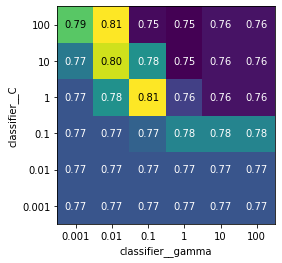

SVM rbf
R^2: 0.805
recall_score: 0.805
f1_score: 0.805
accuracy_score: 0.805


In [21]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='rbf'))
])
param_grid = {
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_1 = GridSearchCV(pipe, param_grid, cv=kfold)
grid_1.fit(X_train, y_train)
grid_1.best_params_
results = pd.DataFrame(grid_1.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()
models.append(('SVM rbf', grid_1.best_estimator_))
scores_1 = get_scores(*models[-1])
print_scores(scores_1)

In [22]:
df = pd.DataFrame(data=scores_1, index=[0])
df

,method,precision,recall,f1,accuracy
0,SVM rbf,0.805,0.805,0.805,0.805


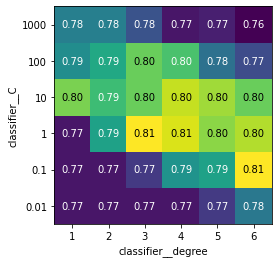

SVM poly
R^2: 0.795
recall_score: 0.795
f1_score: 0.795
accuracy_score: 0.795


,method,precision,recall,f1,accuracy
0,SVM rbf,0.805,0.805,0.805,0.805
1,SVM poly,0.795,0.795,0.795,0.795


In [23]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='poly'))
])
param_grid = {
            'classifier__degree': [i+1 for i in range(6)],
            'classifier__C': [0.01, 0.1, 1, 10, 100, 1000]
}
grid_2 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=4)
grid_2.fit(X_train, y_train)
grid_2.best_params_
results = pd.DataFrame(grid_2.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)
heatmap(scores, xlabel='classifier__degree', xticklabels=param_grid['classifier__degree'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()
models.append(('SVM poly', grid_2.best_estimator_))
scores_2 = get_scores(*models[-1])
print_scores(scores_2)
df.loc[1] = scores_2
df

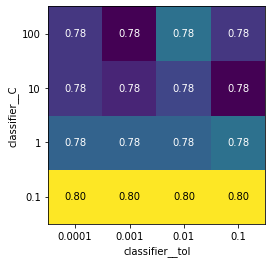

SVM linear
R^2: 0.785
recall_score: 0.785
f1_score: 0.785
accuracy_score: 0.785


,method,precision,recall,f1,accuracy
0,SVM rbf,0.805,0.805,0.805,0.805
1,SVM poly,0.795,0.795,0.795,0.795
2,SVM linear,0.785,0.785,0.785,0.785


In [24]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='linear'))
])
param_grid = {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__tol': [1e-4, 1e-3, 1e-2, 1e-1]
}
grid_3 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=4)
grid_3.fit(X_train, y_train)
grid_3.best_params_
results = pd.DataFrame(grid_3.cv_results_)
scores = np.array(results.mean_test_score).reshape(4, 4)
heatmap(scores, xlabel='classifier__tol', xticklabels=param_grid['classifier__tol'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()
models.append(('SVM linear', grid_3.best_estimator_))
scores_3 = get_scores(*models[-1])
print_scores(scores_3)
df.loc[2] = scores_3
df

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


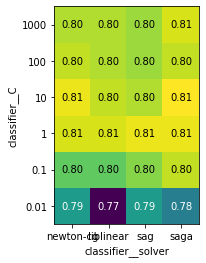

Linear Regression
R^2: 0.82
recall_score: 0.82
f1_score: 0.82
accuracy_score: 0.82


,method,precision,recall,f1,accuracy
0,SVM rbf,0.805,0.805,0.805,0.805
1,SVM poly,0.795,0.795,0.795,0.795
2,SVM linear,0.785,0.785,0.785,0.785
3,Linear Regression,0.820,0.820,0.820,0.820


In [25]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LogisticRegression())
])
param_grid = {
            'classifier__solver': ['newton-cg', 'liblinear', 'sag', 'saga'],
            'classifier__C': [0.01, 0.1, 1, 10, 100, 1000]
}
grid_4 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=4)
grid_4.fit(X_train, y_train)
grid_4.best_params_
results = pd.DataFrame(grid_4.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 4)
heatmap(scores, xlabel='classifier__solver', xticklabels=param_grid['classifier__solver'], ylabel='classifier__C', yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()
models.append(('Linear Regression', grid_4.best_estimator_))
scores_4 = get_scores(*models[-1])
print_scores(scores_4)
df.loc[3] = scores_4
df